### Импорты библиотек

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchaudio
import librosa
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import Levenshtein
import random
import torchaudio.transforms as transforms
import torch.nn.functional as F
from tqdm.notebook import tqdm
import os
import wandb

### Настройка воспроизводимости

In [2]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

SEED = 42
set_seed(SEED)

### Настройка логирования

In [3]:
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: timgainutdinov (timurgainutdinov) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

### Константы

In [4]:
DATA_DIR = "data/"
TRAIN_CSV_PATH = DATA_DIR + "train.csv"
TEST_CSV_PATH = DATA_DIR + "test.csv"
SUBMISSION_CSV_PATH = DATA_DIR + "sample_submission.csv"
AUDIO_DIR = DATA_DIR + "morse_dataset/morse_dataset"

SAMPLE_RATE = 8000  # Частота дискретизации

### Работа с символами

Символы, которые будем распознавать из аудиосигнала.

In [5]:
SYMBOLS = ".-/ "

Словарь для преобразования кода морзе в текст и обратно.

In [6]:
CHAR_TO_MORSE = {
    'А': '.-', 'Б': '-...', 'В': '.--', 'Г': '--.', 'Д': '-..',
    'Е': '.', 'Ж': '...-', 'З': '--..', 'И': '..', 'Й': '.---',
    'К': '-.-', 'Л': '.-..', 'М': '--', 'Н': '-.', 'О': '---',
    'П': '.--.', 'Р': '.-.', 'С': '...', 'Т': '-', 'У': '..-',
    'Ф': '..-.', 'Х': '....', 'Ц': '-.-.', 'Ч': '---.', 'Ш': '----',
    'Щ': '--.-', 'Ъ': '.--.-.', 'Ы': '-.--', 'Ь': '-..-', 'Э': '..-..',
    'Ю': '..--', 'Я': '.-.-',
    '0': '-----', '1': '.----', '2': '..---', '3': '...--', '4': '....-',
    '5': '.....', '6': '-....', '7': '--...', '8': '---..', '9': '----.',
    ' ': '/', 
    '#': '--.--' # Определено на основании просмотра мел-спектрограмм сигналов с данным символом
}

MORSE_TO_CHAR = {v: k for k, v in CHAR_TO_MORSE.items()}

Функции для преобразований.

In [ ]:
def morse_to_text(morse_code):
    """
    Преобразует код Морзе в текст
    
    Args:
        morse_code (str): Строка с кодом Морзе (точки, тире, слэши и пробелы)
    
    Returns:
        str: Декодированный текст
    """
    text = ""

    morse_code = morse_code.replace("  ", " / ").strip()
    # Разделяем код Морзе на отдельные группы символов
    morse_letters = morse_code.split(' ')
    
    for letter in morse_letters:
        if letter:
            if letter == '/': # обработка пробелов
                text += ' '
            else: # обработка остальных символов
                # для неизвестных символов устанавливаем '?'
                text += MORSE_TO_CHAR.get(letter, '?') 
    return text.strip()


def text_to_morse(text):
    """
    Преобразует текст в код Морзе
    
    Args:
        text (str): Текст для преобразования
    
    Returns:
        str: Код Морзе
    """
    morse_code = ""
    for char in text.upper():
        if char in CHAR_TO_MORSE:
            morse_code += CHAR_TO_MORSE[char] + " "
    return morse_code.strip()

### Визуализация мелспектрограммы

In [8]:
array, sample_rate = librosa.load(f"{AUDIO_DIR}/34984.opus", sr=SAMPLE_RATE)

In [9]:
S = librosa.feature.melspectrogram(y=array, sr=SAMPLE_RATE, 
                                   n_mels=128, n_fft=1024, 
                                   hop_length=1024//4)

In [10]:
n_mels = 128  # Количество мел-фильтров для спектрограммы
n_fft = 512  # Размер окна FFT
hop_length = n_fft//4  # Шаг между окнами FFT

def visualize_melspectrogram(file_path, sample_rate=SAMPLE_RATE, 
                             n_mels=n_mels, n_fft=n_fft, hop_length=hop_length):
    array, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE, duration=12)
    
    S = librosa.feature.melspectrogram(y=array, sr=SAMPLE_RATE, 
                                       n_mels=n_mels, n_fft=n_fft, hop_length=hop_length)
    
    S_dB = librosa.power_to_db(S, ref=np.max)

    plt.figure().set_figwidth(12)
    librosa.display.specshow(S_dB, x_axis="time", y_axis="mel", sr=SAMPLE_RATE, 
                             n_fft=n_fft, hop_length=hop_length)
    plt.colorbar()
    plt.show()

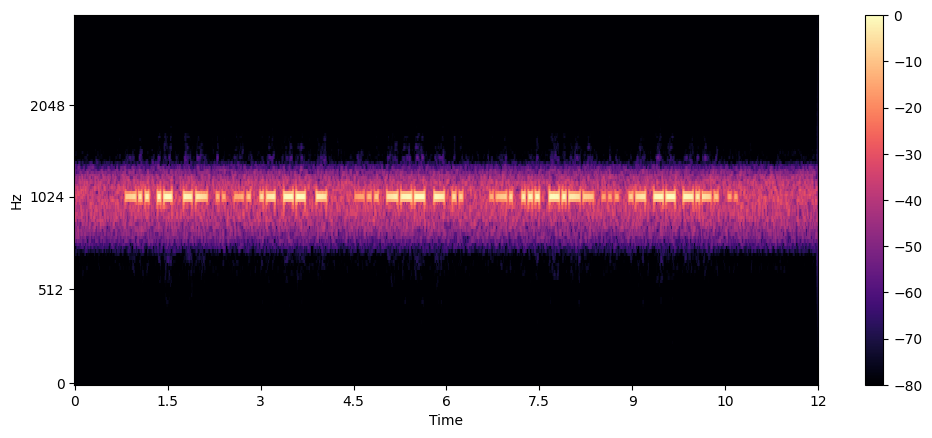

In [11]:
visualize_melspectrogram(f"{AUDIO_DIR}/34984.opus")

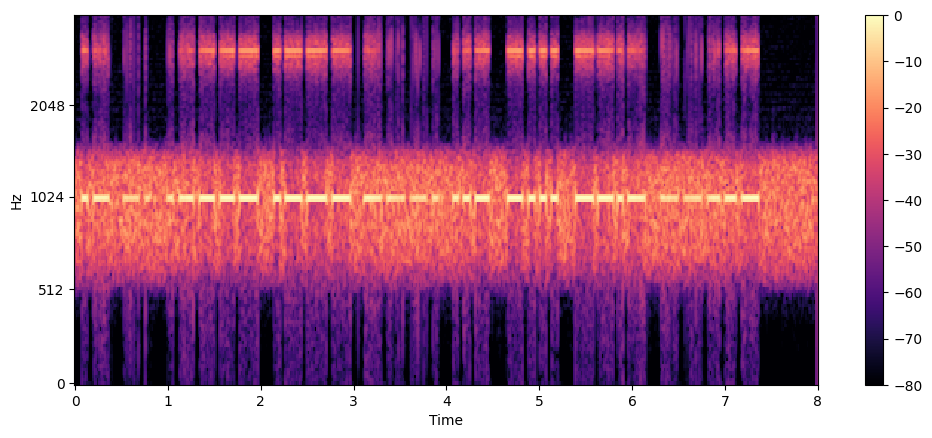

In [12]:
visualize_melspectrogram(f"{AUDIO_DIR}/4968.opus")

Хорошо видны сигналы кода Морзе.

### Преобразование для получения мелспектрограмм

In [13]:
def audio_transform(waveform, n_mels=128, n_fft=1024, hop_length=256, normalize_type=None):
    mel_spec = transforms.MelSpectrogram(
        sample_rate=SAMPLE_RATE,
        n_mels=n_mels,
        n_fft=n_fft,
        hop_length=hop_length
    )(waveform)
    
    processors = {
        "Standard": lambda x: (x - x.mean()) / x.std(),
        "MinMax": lambda x: (x - x.min()) / (x.max() - x.min()),
        "Logdb": lambda x: torch.from_numpy(librosa.power_to_db(x.numpy(), ref=np.max)).float()
    }
    
    return processors.get(normalize_type, lambda x: x)(mel_spec)

### Токенизатор для символов Морзе

In [14]:
class MorseTokenizer:
    def __init__(self, symbols=SYMBOLS):
        self.symbols = sorted(set(symbols))
        self.char2idx = {c: i + 1 for i, c in enumerate(self.symbols)}  # 0 = blank
        self.idx2char = {i + 1: c for i, c in enumerate(self.symbols)}
        self.idx2char[0] = ''  # Blank token для CTC

    def encode(self, text):
        return [self.char2idx[c] for c in text if c in self.char2idx]

    def decode(self, ids):
        return ''.join([self.idx2char.get(i, '') for i in ids if i in self.idx2char])

### Класс для работы с датасетом

In [15]:
class MorseDataset(Dataset):
    def __init__(self, filepaths, tokenizer, transcripts=None, transform=None, n_mels=128):
        self.filepaths = filepaths
        self.transcripts = transcripts
        self.tokenizer = tokenizer
        self.transform = transform
        self.n_mels = n_mels

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, idx):
        waveform, _ = torchaudio.load(self.filepaths[idx])
        mel_spec = self.transform(waveform).squeeze(0).transpose(0, 1)
        
        if self.transcripts:
            target_ids = self.tokenizer.encode(self.transcripts[idx])
            return mel_spec, torch.tensor(target_ids, dtype=torch.long)
            
        return mel_spec, torch.tensor([], dtype=torch.long)

### Определяем архитектуру модели для распознавания кода Морзе

In [16]:
class MorseCTCModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super().__init__()
        
        # Параллельные свертки с разными kernel_size
        # для захвата патернов различной длины,
        # а также для устойчивости к временным вариациям сигналов
        self.conv3 = nn.Sequential(
            nn.Conv1d(input_dim, 64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        
        self.conv5 = nn.Sequential(
            nn.Conv1d(input_dim, 64, kernel_size=5, padding=2),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        
        self.conv7 = nn.Sequential(
            nn.Conv1d(input_dim, 64, kernel_size=7, padding=3),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        
        # Объединяющий слой после конкатенации
        # для агрегации информации из разных сверток
        self.merge = nn.Sequential(
            nn.Conv1d(192, 128, kernel_size=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        # Двунаправленная LSTM для более эффективного захвата контекста
        self.rnn = nn.LSTM(128, hidden_dim, num_layers=3, batch_first=True, 
                          bidirectional=True, dropout=0.3)
        # Полносвязный слой для уменьшения размерности 
        # и выявления дополнительных паттернов
        self.linear = nn.Linear(hidden_dim * 2, hidden_dim)

        self.classifier = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):

        x = x.transpose(1, 2)
        
        # Применяем параллельные свертки
        x3 = self.conv3(x)
        x5 = self.conv5(x)
        x7 = self.conv7(x)
        
        # Агрегируем результаты
        x = torch.cat([x3, x5, x7], dim=1)
        x = self.merge(x)
        
        x = x.transpose(1, 2)

        # Применяем LSTM
        x, _ = self.rnn(x)

        # Применяем полносвязный слой
        x = self.linear(x)
        x = nn.ReLU()(x)
        
        # Применяем слой классификации
        logits = self.classifier(x)

        return logits.log_softmax(dim=-1)

### Функция для одного шага обучения модели

In [17]:
def train_step(model, batch, criterion, device):
    inputs, targets, input_lengths = batch
    inputs = inputs.to(device)
    
    # Прямой проход
    log_probs_from_model = model(inputs)
    
    # Получаем длины целевых последовательностей
    target_lengths = torch.tensor([len(t) for t in targets], dtype=torch.long)
    
    # Форматируем таргеты для CTC
    targets_concat = torch.cat(targets)
    
    log_probs = log_probs_from_model.transpose(0, 1)
    
    # Рассчитываем значение функции потерь
    loss = criterion(log_probs, targets_concat, input_lengths, target_lengths)
    
    return loss, log_probs_from_model

### Функция для преобразования предсказаний модели в текст

In [18]:
def ctc_decode(log_probs, tokenizer, morse_to_text_fn=morse_to_text):
    pred_ids = log_probs.argmax(-1).cpu().numpy()
    morse_codes = []
    
    for seq in pred_ids:
        # Применяем CTC collapsing (убираем повторения и пустые токены)
        prev = None
        decoded = []
        for idx in seq:
            if idx != prev and idx != 0:  # 0 - это blank token
                decoded.append(idx)
            prev = idx
        
        # Получаем код Морзе из индексов
        morse_code = tokenizer.decode(decoded)
        morse_codes.append(morse_code)

    # Преобразуем код Морзе в текст
    text_results = []
    
    for morse_code in morse_codes:
        # Обрабатываем последовательности символов Морзе
        processed_code = ""
        current_char = ""
        for char in morse_code:
            if char in ".-":
                current_char += char
            elif char == " " or char == "/":
                if current_char:
                    processed_code += current_char + " "
                    current_char = ""
                if char == "/":
                    processed_code += "/ "
        
        # Добавляем последний символ, если он есть
        if current_char:
            processed_code += current_char
            
        # Декодируем текст
        text = morse_to_text_fn(processed_code.strip())
        text_results.append(text)

    return text_results, morse_codes

### Функция для вычисления среднего расстояния Левенштейна

In [19]:
def compute_levenshtein_distance(predictions, targets):
    distances = []
    for pred, target in zip(predictions, targets):
        if not pred and not target:  # Если обе строки пустые
            distances.append(0)
        elif not pred:  # Если предсказание пустое, расстояние равно длине целевого значения
            distances.append(len(target))
        elif not target:  # Если целевое значение пустое, расстояние равно длине предсказания
            distances.append(len(pred))
        else:  # Вычисляем расстояние Левенштейна для непустых строк
            distance = Levenshtein.distance(pred, target)
            distances.append(distance)

    return sum(distances) / len(distances) if distances else 0

### Функция для подготовки батчей данных

In [20]:
def collate_fn(batch):
    specs, targets = zip(*batch)
    # Получаем длины последовательностей
    spec_lengths = [s.shape[0] for s in specs]

    # Паддинг мелспектрограмм
    max_len = max(spec_lengths)
    padded_specs = [F.pad(s, (0, 0, 0, max_len - s.shape[0])) for s in specs]
    padded_specs = torch.stack(padded_specs)
    
    # Таргеты без паддинга
    targets = [t for t in targets]

    return padded_specs, targets, torch.tensor(spec_lengths, dtype=torch.long)

### Функции для извлечения оптимизатора и планировщика

In [21]:
def get_optimizer(model, optimizer_name='adam', optimizer_params=None):
    OPTIMIZER_MAP = {
        'Adam': optim.Adam,
        'SGD': optim.SGD,
        'AdamW': optim.AdamW,
        'RMSprop': optim.RMSprop,
        'Adagrad': optim.Adagrad,
        'Adamax': optim.Adamax,
        'Adadelta': optim.Adadelta
    }

    constructor = OPTIMIZER_MAP.get(optimizer_name)
    if not constructor:
        raise ValueError(f"Неизвестный оптимизатор: {optimizer_name}")
    return constructor(model.parameters(), **(optimizer_params or {}))


def get_scheduler(optimizer, scheduler_name='ReduceLROnPlateau', scheduler_params=None):
    SCHEDULER_MAP = {
        'ReduceLROnPlateau': optim.lr_scheduler.ReduceLROnPlateau,
        'StepLR': optim.lr_scheduler.StepLR,
        'ExponentialLR': optim.lr_scheduler.ExponentialLR,
        'CosineAnnealingLR': optim.lr_scheduler.CosineAnnealingLR,
        'CosineAnnealingWarmRestarts': optim.lr_scheduler.CosineAnnealingWarmRestarts,
        'LambdaLR': optim.lr_scheduler.LambdaLR,
        'CyclicLR': optim.lr_scheduler.CyclicLR,
        'OneCycleLR': optim.lr_scheduler.OneCycleLR
    }

    constructor = SCHEDULER_MAP.get(scheduler_name)
    if not constructor:
        raise ValueError(f"Неизвестное имя планировщика: {scheduler_name}")
    return constructor(optimizer, **(scheduler_params or {}))

### Функция для обучения сети на одной эпохе

In [22]:
def train_eval(
    model, train_loader, val_loader, val_texts, tokenizer, 
    epoch, num_epochs, optimizer, criterion, device, grad_clipping_norm
):
    # Обучение
    model.train()
    train_loss = 0.0
    
    for batch in tqdm(train_loader, desc=f"Эпоха {epoch+1}/{num_epochs} [Обучение]", leave=True):
        optimizer.zero_grad()
        loss, _ = train_step(model, batch, criterion, device)
        loss.backward()
        
        if grad_clipping_norm is not None:
            # градиентный клиппинг, чтобы избежать взрыва градиентов
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=grad_clipping_norm)
        
        optimizer.step()
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    
    # Валидация
    model.eval()
    val_loss = 0.0
    all_predictions = []
    all_morse_codes = []
    all_targets = val_texts

    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Эпоха {epoch+1}/{num_epochs} [Валидация]", leave=True):
            # Вычисляем потери
            loss, log_probs_from_model = train_step(model, batch, criterion, device)
            val_loss += loss.item()
            
            # Декодируем предсказания
            decoded_texts, morse_codes = ctc_decode(log_probs_from_model, tokenizer)            
            
            # Добавляем предсказания
            all_predictions.extend(decoded_texts)
            all_morse_codes.extend(morse_codes)
    
    val_loss /= len(val_loader)
    
    # Вычисляем среднее расстояние Левенштейна
    text_lev_distance = compute_levenshtein_distance(all_predictions, all_targets)
    print(all_morse_codes[:10])
    print(all_predictions[:10])
    print(val_texts[:10])
    return train_loss, val_loss, text_lev_distance

### Функция для обучения и инференса сети

In [23]:
def fit(
    config,
    patience=3,
    desc=""
):
    """Функция для обучения модели."""
    # Имя эксперимента для логирования результатов
    experiment_name = (
        f"{desc}_"
        f"mels_{config['n_mels']}_"
        f"fft_{config['n_fft']}_"
        f"hop_{config['hop_length']}_"
        f"norm_{config['normalize_type']}_"
        f"bs_{config['batch_size']}_"
        f"ep_{config['epochs']}_"
        f"opt_{config['optimizer']}_"
        f"sch_{config['scheduler']}_"
        f"clip_{config['grad_clipping_norm']}"
    )
    # Используем wandb для хранения результатов экспериментов
    with wandb.init(project="kontur", config=config, name=experiment_name):    
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

        tokenizer = MorseTokenizer(SYMBOLS)
        num_classes = len(tokenizer.char2idx) + 1 # "+1" для blank токена
        
        model = MorseCTCModel(input_dim=config["n_mels"], hidden_dim=128, num_classes=num_classes)
        model = model.to(device)
        
        wandb.run.summary["model_architecture"] = str(model)
        
        train_df = pd.read_csv(TRAIN_CSV_PATH)
        train_paths = [f"{AUDIO_DIR}/{fname}" for fname in train_df["id"]]

        # Фильтруем только существующие файлы
        valid_indices = [i for i, path in enumerate(train_paths) if os.path.exists(path)]
        if len(valid_indices) < len(train_paths):
            print(f"Пропущено {len(train_paths) - len(valid_indices)} файлов, которые не найдены")
        
        train_paths = [train_paths[i] for i in valid_indices]
        train_texts = [train_df["message"].iloc[i] for i in valid_indices]
        
        # Преобразуем текстовые сообщения в код Морзе
        train_morse = [text_to_morse(message) for message in train_texts]
        
        train_paths, val_paths, train_morse, val_morse, train_texts, val_texts = train_test_split(
            train_paths, train_morse, train_texts, test_size=config["val_ratio"], random_state=SEED
        )
        # Определяем функцию для преобразования аудио в мел-спектрограмму
        def current_audio_transform(waveform):
            return audio_transform(waveform, n_mels=config["n_mels"], n_fft=config["n_fft"], 
                                hop_length=config["hop_length"], normalize_type=config["normalize_type"])

        train_ds = MorseDataset(train_paths, tokenizer, n_mels=config["n_mels"], transcripts=train_morse, transform=current_audio_transform)
        val_ds = MorseDataset(val_paths, tokenizer, n_mels=config["n_mels"], transcripts=val_morse, transform=current_audio_transform)
        
        train_loader = DataLoader(train_ds, batch_size=config["batch_size"], shuffle=True, collate_fn=collate_fn)
        val_loader = DataLoader(val_ds, batch_size=config["batch_size"], shuffle=False, collate_fn=collate_fn)
        
        criterion = nn.CTCLoss(blank=0, zero_infinity=True)
        optimizer = get_optimizer(model, optimizer_name=config["optimizer"], optimizer_params=config["optimizer_params"])
        
        scheduler = None
        if config["scheduler"] is not None:
            scheduler = get_scheduler(optimizer, scheduler_name=config["scheduler"], scheduler_params=config["scheduler_params"])
        
        best_val_loss = float('inf')
        # Счетчик для ранней остановки
        patience_counter = 0
        best_model_path = f'best_model_{experiment_name}.pth'
        # Цикл обучения сети
        for epoch in range(config["epochs"]):
            train_loss, val_loss, text_lev_distance = train_eval(
                model, train_loader, val_loader, val_texts, tokenizer, 
                epoch, config["epochs"], optimizer, criterion, device, config["grad_clipping_norm"]
            )

            if scheduler is not None:
                scheduler.step(val_loss)
                # Логируем текущую скорость обучения
                current_lr = getattr(scheduler, '_last_lr', [optimizer.param_groups[0]['lr']])[0]
                wandb.log({"learning_rate": current_lr, "epoch": epoch+1})
            
            # Сохраняем лучшую модель
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                torch.save(model.state_dict(), best_model_path)
                wandb.run.summary.update({
                    "best_val_loss": val_loss,
                    "best_epoch": epoch+1
                })
            else:
                # Для реализации ранней остановки
                patience_counter += 1
                print(f"Нет улучшения в течение {patience_counter} эпох(и)")
                if patience_counter >= patience:
                    print(f"Early stopping на эпохе {epoch+1}")
                    wandb.run.summary.update({
                        "early_stopped": True,
                        "stopped_epoch": epoch+1
                    })
                    break
            # Логируем результаты
            wandb.log({
                "loss/train": train_loss,
                "loss/val": val_loss,
                "metric/train": text_lev_distance,
                "epoch": epoch+1
            })

            print(f"Эпоха {epoch+1}/{config['epochs']} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                    f"Best Val Loss: {best_val_loss:.4f}, Metric: {text_lev_distance:.4f}")

    return model

def predict(config, model_path, 
            test_csv_path=TEST_CSV_PATH, submission_csv_path="submission.csv", 
            batch_size=32, device=None):
    """Функция для предсказания на тестовом наборе данных."""

    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
    # Загружаем тестовые данные
    test_df = pd.read_csv(test_csv_path)
    test_paths = [f"{AUDIO_DIR}/{fname}" for fname in test_df["id"]]
    
    # Проверяем наличие файлов
    valid_indices = []
    valid_paths = []
    for i, path in enumerate(test_paths):
        if os.path.exists(path):
            valid_indices.append(i)
            valid_paths.append(path)
        else:
            print(f"Файл не найден: {path}")
    
    tokenizer = MorseTokenizer(SYMBOLS)
    num_classes = len(tokenizer.char2idx) + 1
    
    model = MorseCTCModel(input_dim=config["n_mels"], hidden_dim=128, num_classes=num_classes)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model = model.to(device)
    model.eval()
    
    def current_audio_transform(waveform):
        return audio_transform(waveform, n_mels=config["n_mels"], n_fft=config["n_fft"], 
                            hop_length=config["hop_length"], normalize_type=config["normalize_type"])
    
    test_ds = MorseDataset(valid_paths, tokenizer, transcripts=None, transform=current_audio_transform)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
    
    # Выполняем предсказания
    all_predictions = []
    test_ids = [test_df["id"].iloc[i] for i in valid_indices]
    
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Выполнение предсказаний на тестовом наборе"):
            inputs, _, _ = batch
            inputs = inputs.to(device)
            
            # Получаем предсказания
            log_probs = model(inputs)
            
            # Декодируем предсказания в текст
            decoded_texts, _ = ctc_decode(log_probs, tokenizer)
            all_predictions.extend(decoded_texts)

    # Последние 17 сообщений заменяем на известные значения
    last_17 = [
        'ВНИМАНИЕ ВСЕМ КОЛОНИЯМ',
        'МЫ ПОДТВЕРЖДАЕМ ЦИВИЛИЗАЦИЯ ЗЕМЛИ ПЕРЕЖИЛА ВЕЛИКУЮ ТЬМУ',
        'НАШ ДОСТУП К ДРЕВНИМ АРХИВАМ УТРАЧЕН',
        'МЫ ВНОВЬ ПОСТИГАЕМ МУДРОСТЬ ПРОШЛОГО ШАГ ЗА ШАГОМ',
        'ТЕПЕРЬ ВОЦАРИЛСЯ МИР',
        'РАСПРИ ОСТАЛИСЬ ПОЗАДИ',
        'МЫ ПОСТАВИЛИ БЛАГО БЛИЖНЕГО ПРЕВЫШЕ ЛИЧНЫХ ВЫГОД И ЖЕЛАНИЙ',
        'МЫ ВНОВЬ СОЗДАЛИ АЗБУКУ ТЕЛЕГРАФА',
        'НО НЕ МОЖЕМ РУЧАТЬСЯ ЗА АБСОЛЮТНУЮ ВЕРНОСТЬ СИМВОЛОВ',
        'ЕСЛИ ВЫ СЛЫШИТЕ ЕЕ ЭТО ПОСЛАНИЕ ОТКЛИКНИТЕСЬ',
        'НА ЧАСТОТЕ ПЕРЕДАЧИ УВЕЛИЧЕННОЙ НА 20 КИЛОЦИКЛОВ',
        'СВЯЗЬ ПОДДЕРЖИВАЕТСЯ ВРУЧНУЮ НЕУТОМИМЫМИ ПАЛЬЦАМИ НАШИХ ОПЕРАТОРОВ',
        'СКОРО МЫ ВНОВЬ ПОСТИГНЕМ ТАЙНЫ РАКЕТНЫХ ДВИГАТЕЛЕЙ',
        'СМОЖЕМ ОТПРАВИТЬ ЗА ВАМИ СПАСИТЕЛЬНЫЙ ЧЕЛНОК',
        'ЕСЛИ ВЫ ПОЖЕЛАЕТЕ ВЕРНУТЬСЯ ДОМОЙ',
        'СВЕТ СОЛНЦА ДАРИТ ЖИЗНЬ КАЖДОМУ',
        'КОНЕЦ ПЕРЕДАЧИ'
    ]

    all_predictions_edited = all_predictions[:-17] + last_17

    results_df = pd.DataFrame({
        "id": test_ids[:len(all_predictions_edited)],
        "message": all_predictions_edited
    })
    
    # Сохраняем результаты
    results_df.to_csv(submission_csv_path, index=False)
    print(f"Результаты сохранены в {submission_csv_path}")    
    
    return results_df

### Установка гиперпараметров и обучение сети

In [ ]:
### ПАРАМЕТРЫ МЕЛ-СПЕКТРОГРАММЫ ###
# Параметры подобраны с использованием Optuna
N_MELS = 128  # Количество мел-фильтров для спектрограммы
N_FFT = 1024  # Размер окна FFT
HOP_LENGTH = N_FFT//4  # Шаг между окнами FFT
NORMALIZE_TYPE = None

### ПАРАМЕТРЫ ОБУЧЕНИЯ ###
# Параметры подобраны с использованием Optuna
BATCH_SIZE = 32  # Размер батча
EPOCHS = 50  # Количество эпох
VAL_RATIO = 0.05  # Доля валидационной выборки

### ПАРАМЕТРЫ ОПТИМИЗАТОРА ###
# Параметры подобраны с использованием Optuna
OPTIMIZER = "AdamW"
OPTIMIZER_PARAMS = {
    "lr": 0.0016743473673696482,  # Начальная скорость обучения
    "weight_decay": 0.0001272266566479598  # Регуляризация L2
}

### ПАРАМЕТРЫ ПЛАНИРОВЩИКА ###
SCHEDULER = "ReduceLROnPlateau"
SCHEDULER_PARAMS = {
    "mode": "min",
    "factor": 0.5, # Уменьшает скорость обучения в 2 раза, 
                   # если значение функции потерь не уменьшается
    "patience": 1
}


### ПАРАМЕТРЫ ГРАДИЕНТНОГО КЛИППИНГА ###
# Параметры подобраны с использованием Optuna
GRAD_CLIPPING_NORM = 3.4631732030114635

# Описание для логирования
DESC = "custom"

# Конфигурация для обучения
CONGFIG = {
    "n_mels": N_MELS,
    "n_fft": N_FFT,
    "hop_length": HOP_LENGTH,
    "normalize_type": NORMALIZE_TYPE,
    "batch_size": BATCH_SIZE,
    "epochs": EPOCHS,
    "val_ratio": VAL_RATIO,
    "optimizer": OPTIMIZER,
    "optimizer_params": OPTIMIZER_PARAMS,
    "scheduler": SCHEDULER,
    "scheduler_params": SCHEDULER_PARAMS,
    "grad_clipping_norm": GRAD_CLIPPING_NORM
}

# Обучение сети
model = fit(
    config=CONGFIG,
    desc=DESC,
    patience=5
)

### Выполнение предсказаний на тестовом наборе данных

In [ ]:
model_path = "best_model_custom_mels_128_fft_1024_hop_256_norm_None_bs_32_ep_50_opt_AdamW_sch_ReduceLROnPlateau_clip_3.4631732030114635.pth"
predictions = predict(CONGFIG, model_path, submission_csv_path="submission_with_17_last.csv")